# Imports

In [2]:
from ast import literal_eval
import functools
import json
import os
import random
import shutil

# Scienfitic packages
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import torch
import datasets
from torch import cuda
torch.set_grad_enabled(False)

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook",
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities

from general_utils import (
  ModelAndTokenizer,
  make_inputs,
  decode_tokens,
  find_token_range,
  predict_from_input,
)

from patchscopes_utils import *

import tqdm
tqdm.tqdm.pandas()

In [3]:
batch_size_scale = 4
# Load model

model_name = "lmsys/vicuna-7b-v1.1"
sos_tok = False


torch_dtype = torch.float16


my_device = torch.device("cuda:0")

mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=torch_dtype,
    device=my_device,
)
mt.set_hs_patch_hooks = set_hs_patch_hooks_llama_batch
mt.model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(
  

# MultiHop reasoning experiments

In [4]:
def generate_baseline_multihop(
    mt, df, batch_size=256 // batch_size_scale, max_gen_len=10,
):
    def _generate_baseline_single_batch(batch_df):
        batch_size = len(batch_df)
        cases = [("baseline_hop2", "hop2"),
                 ("baseline_hop3", "hop3"),
                 ("baseline_multihop3", "hop3"),
                ]
        results = {}
        for target_col, object_col in cases:

            target_baseline_batch = np.array(batch_df[target_col])
            object_batch = np.array(batch_df[object_col])


            # Step 0: run the the model on target prompt baseline (having the subject token in input rather than patched)
            # The goal of this step is to calculate whether the model works correctly by default, and to calculate surprisal
            inp_target_baseline = make_inputs(mt.tokenizer, target_baseline_batch, mt.device)
            seq_len_target_baseline = len(inp_target_baseline["input_ids"][0])
            output_target_baseline_toks = mt.model.generate(
                inp_target_baseline["input_ids"],
                max_length=seq_len_target_baseline + max_gen_len,
                pad_token_id=mt.model.generation_config.eos_token_id,
            )[:, seq_len_target_baseline:]
            generations_baseline = decode_tokens(mt.tokenizer, output_target_baseline_toks)
            generations_baseline_txt = np.array([" ".join(sample_gen) for sample_gen in generations_baseline])


            is_correct_baseline = np.array([
                (object_batch[i] in generations_baseline_txt[i] or
                 object_batch[i].replace(" ", "") in generations_baseline_txt[i].replace(" ", ""))
                for i in range(batch_size)
            ])
            results.update(
                {
                f"generations_{target_col}": generations_baseline_txt,
                f"is_correct_{target_col}": is_correct_baseline,
                }
            )

        return results

    results = {}
    n_batches = len(df) // batch_size
    if len(df)%batch_size !=0:
        n_batches +=1
    for i in tqdm.tqdm(range(n_batches)):
        cur_df = df.iloc[batch_size * i : batch_size * (i + 1)]
        batch_results = _generate_baseline_single_batch(cur_df)
        for key, value in batch_results.items():
            if key in results:
                results[key] = np.concatenate((results[key], value))
            else:
                results[key] = value

    return results


# Experiment 1: Multihop Product Company CEO tuples

This is a subset made only from (product, company) and (company, CEO) tuples from the LRE dataset.
We only picked 3 (company, CEO) tuples, and 15 (product, company) tuples for each that the model is more likely to know the answer to.

This is an exploratory experiment. There is a more complete experiment later in the colab.
Hop 1: Product
Hop 2: company
Hop 3: CEO

In [5]:
multihop_samples = {
    ("Satya Nadella", "Microsoft"): ["WinDbg", ".NET Framework", "Internet Explorer", "MS-DOS", "Office Open XML",
               "TypeScript", "Bing Maps Platform", "Outlook Express", "PowerShell", "Windows 95",
               "Xbox 360", "Zune", "Visual Basic Script", "Virtual Hard Disk", "Robocopy",
              ],
    ("Tim Cook", "Apple"): ["Siri", "App Store", "CarPlay", "MacBook Air", "Xcode",
               "macOS", "iWork", "Safari", "QuickTime", "TextEdit",
               "WebKit", "QuickDraw", "Time Machine (macOS)", "MessagePad", "Macbook Pro",
              ],
    ("Sundar Pichai", "Google"): ["Chromecast", "Chromebook", "Wear OS", "G Suite", "Picasa",
                "WebP Lossless", "General Transit Feed Specification Lossless", "Cloud Spanner", "Android TV", "Android Runtime",
                "Android Jelly Bean", "Android Auto", "App Inventor", "Chromebook Pixel", "Project Ara",
               ]
}

def generate_multihop_data_ceo(fdir_out="./outputs/factual", batch_size=512 // batch_size_scale, max_gen_len=20, replace=False):
    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    fname_out = "multihop_product_company_ceo"
    if not replace and os.path.exists(f"{fdir_out}/{fname_out}.pkl"):
        print(f"File {fdir_out}/{fname_out}.pkl exists. Skipping generation. Reading file...")
        df = pd.read_pickle(os.path.join(fdir_out, f"{fname_out}.pkl"))
        return df
    prompt_source_template = "{} was created by"
    prompt_target_template = "Who is the current CEO of {}"
    sample_id = 0

    print("Step 1: Prepare dataset...")
    records = []

    for key, value in multihop_samples.items():
        hop3, hop2 = key
        for hop1 in value:
            # hop1: Product
            # hop2: Company
            # hop3: CEO
            records.append({
                "sample_id": sample_id,
                "prompt_source": prompt_source_template.replace("{}", hop1),
                "position_source": -1, # always doing next token prediction
                "prompt_target": prompt_target_template,
                "position_target": -1,

                "baseline_hop2":  f"{hop1} was created by", #  hop2
                "baseline_hop3":  f"Who is the current CEO of {hop2}", # hop3
                "baseline_multihop3": f"Who is the current CEO of the company that created {hop1}", # hop3

                "hop1": hop1,
                "hop2": hop2,
                "hop3": hop3,
            })
            sample_id +=1

    # Step 2: Compute baseline generations
    print("Step 2: Compute baseline generations...")
    df = pd.DataFrame.from_records(records)
    eval_results = generate_baseline_multihop(mt, df, batch_size=batch_size, max_gen_len=max_gen_len)
    for key, value in eval_results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, f"{fname_out}.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, f"{fname_out}.pkl"))
    return df

In [6]:
multihop_df = generate_multihop_data_ceo(batch_size=128 // batch_size_scale, max_gen_len=20)

File ./outputs/factual/multihop_product_company_ceo.pkl exists. Skipping generation. Reading file...


In [7]:
def evaluate_attriburte_exraction_batch_multihop(
    mt, df, batch_size=256 // batch_size_scale, max_gen_len=10, transform=None
):
    def _evaluate_attriburte_exraction_single_batch(batch_df):
        batch_size = len(batch_df)
        prompt_source_batch = np.array(batch_df["prompt_source"])
        prompt_target_batch = np.array(batch_df["prompt_target"])
        layer_source_batch = np.array(batch_df["layer_source"])
        layer_target_batch = np.array(batch_df["layer_target"])
        position_source_batch = np.array(batch_df["position_source"])
        position_target_batch = np.array(batch_df["position_target"])

        object_batch = np.array(batch_df["hop3"])


        # Adjust position_target to be absolute rather than relative
        inp_target = make_inputs(mt.tokenizer, prompt_target_batch, mt.device)
        for i in range(batch_size):
            if position_target_batch[i] < 0:
                position_target_batch[i] += len(inp_target["input_ids"][i])

        # Step 1: run the the model on source without patching and get the hidden representations.
        inp_source = make_inputs(mt.tokenizer, prompt_source_batch, mt.device)
        output_orig = mt.model(**inp_source, output_hidden_states=True)

        # hidden_states size (n_layers, n_sample, seq_len, hidden_dim)
        hidden_rep = [
            output_orig.hidden_states[layer_source_batch[i] + 1][i][
                position_source_batch[i]
            ]
            for i in range(batch_size)
        ]
        if transform is not None:
            for i in range(batch_size):
                hidden_rep[i] = transform(hidden_rep[i])

        # Step 2: do second run on target prompt, while patching the input hidden state.
        hs_patch_config = [
            {
                "batch_idx": i,
                "layer_target": layer_target_batch[i],
                "position_target": position_target_batch[i],
                "hidden_rep": hidden_rep[i],
                "skip_final_ln": (
                    layer_source_batch[i]
                    == layer_target_batch[i]
                    == mt.num_layers - 1
                ),
            }
            for i in range(batch_size)
        ]
        patch_hooks = mt.set_hs_patch_hooks(
            mt.model, hs_patch_config, patch_input=False, generation_mode=True
        )

        output = mt.model(**inp_target)

        # NOTE: inputs are left padded,
        # and sequence length is the same across batch
        seq_len = len(inp_target["input_ids"][0])
        output_toks = mt.model.generate(
            inp_target["input_ids"],
            max_length=seq_len + max_gen_len,
            pad_token_id=mt.model.generation_config.eos_token_id,
        )[:, seq_len:]
        generations_patched = decode_tokens(mt.tokenizer, output_toks)
        generations_patched_txt = np.array([
            " ".join(generations_patched[i])
            for i in range(batch_size)
        ])
        is_correct_patched = np.array([
            (object_batch[i] in generations_patched_txt[i]
             or object_batch[i].replace(" ", "") in generations_patched_txt[i].replace(" ", ""))
            for i in range(batch_size)
        ])

        # remove patching hooks
        remove_hooks(patch_hooks)

        cpu_hidden_rep = np.array([hidden_rep[i].detach().cpu().numpy() for i in range(batch_size)])

        results = {
            "generations_patched": generations_patched,
            "is_correct_patched": is_correct_patched,
            "hidden_rep": cpu_hidden_rep,

        }

        return results

    results = {}
    n_batches = len(df) // batch_size
    if len(df)%batch_size !=0:
        n_batches +=1
    for i in tqdm.tqdm(range(len(df) // batch_size)):
        cur_df = df.iloc[batch_size * i : batch_size * (i + 1)]
        batch_results = _evaluate_attriburte_exraction_single_batch(cur_df)
        for key, value in batch_results.items():
            if key in results:
                results[key] = np.concatenate((results[key], value))
            else:
                results[key] = value

    return results

In [8]:
def run_experiment(fname_in, fdir_out, fname_out = "multihop", batch_size=512 // batch_size_scale, n_samples=-1,
                   save_output=True, replace=False, tsv=False):
    print(f"Running experiment on {fname_in}...")
    if not replace and os.path.exists(f"{fdir_out}/{fname_out}.pkl"):
        print(f"File {fdir_out}/{fname_out}.pkl exists. Skipping generation. Reading file...")
        results_df = pd.read_pickle(f"{fdir_out}/{fname_out}.pkl")
        return results_df
    if tsv:
        df = pd.read_csv(f"{fname_in}", sep='\t', header=0)
    else:
        df = pd.read_pickle(f"{fname_in}")
    print(f"\tNumber of samples: {len(df)}")

    # BATCHED
    batch = []
    for layer_source in tqdm.tqdm(range(mt.num_layers)):
        for layer_target in range(mt.num_layers):
            for _, row in df.iterrows():
                item = dict(row)
                item.update({
                    "layer_source": layer_source,
                    "layer_target": layer_target,
                })
                batch.append(item)
    experiment_df = pd.DataFrame.from_records(batch)

    if n_samples > 0 and n_samples<len(experiment_df):
        experiment_df = experiment_df.sample(n=n_samples, replace=False, random_state=42).reset_index(drop=True)

    print(f"\tNumber of datapoints for patching experiment: {len(experiment_df)}")

    eval_results = evaluate_attriburte_exraction_batch_multihop(mt, experiment_df, batch_size=batch_size)

    results_df = experiment_df.head(len(eval_results["is_correct_patched"]))
    for key, value in eval_results.items():
        results_df[key] = list(value)

    if save_output:
        if not os.path.exists(fdir_out):
            os.makedirs(fdir_out)
        results_df.to_csv(f"{fdir_out}/{fname_out}.tsv", sep="\t")
        results_df.to_pickle(f"{fdir_out}/{fname_out}.pkl")

    return results_df

In [9]:
run_experiment("./outputs/factual/multihop_product_company_ceo.pkl",
               "./outputs/results/factual",
               fname_out = "multihop_product_company_ceo", batch_size=128 // batch_size_scale, n_samples=-1,
               save_output=True, replace=False)

Running experiment on ./outputs/factual/multihop_product_company_ceo.pkl...
File ./outputs/results/factual/multihop_product_company_ceo.pkl exists. Skipping generation. Reading file...


,sample_id,prompt_source,position_source,prompt_target,position_target,baseline_hop2,baseline_hop3,baseline_multihop3,hop1,hop2,...,is_correct_baseline_hop2,generations_baseline_hop3,is_correct_baseline_hop3,generations_baseline_multihop3,is_correct_baseline_multihop3,layer_source,layer_target,generations_patched,is_correct_patched,hidden_rep
0,0,WinDbg was created by,-1,Who is the current CEO of {},-1,WinDbg was created by,Who is the current CEO of Microsoft,Who is the current CEO of the company that cre...,WinDbg,Microsoft,...,False,? \n \n a ) Sat ya Nad ella \n b ) Bill G ates...,True,? \n \n I ' m trying to find out who the curre...,False,0,0,"[d, ?, \n, Who, is, the, current, CE, O, of]",False,"[0.01146, -0.03238, -0.00457, -0.0725, -0.0423..."
1,1,.NET Framework was created by,-1,Who is the current CEO of {},-1,.NET Framework was created by,Who is the current CEO of Microsoft,Who is the current CEO of the company that cre...,.NET Framework,Microsoft,...,True,? \n \n a ) Sat ya Nad ella \n b ) Bill G ates...,True,"? \n \n As of 2 0 2 1 , the current CE O of M...",False,0,0,"[d, ?, \n, What, is, the, name, of, the, company]",False,"[0.00357, -0.05588, -0.00783, -0.0799, -0.0405..."
2,2,Internet Explorer was created by,-1,Who is the current CEO of {},-1,Internet Explorer was created by,Who is the current CEO of Microsoft,Who is the current CEO of the company that cre...,Internet Explorer,Microsoft,...,False,? \n \n a ) Sat ya Nad ella \n b ) Bill G ates...,True,"? \n \n As of 2 0 2 1 , the current CE O of M...",False,0,0,"[d, ?, \n, The, current, CE, O, of, BY, D]",False,"[-0.0003967, -0.04077, -0.01026, -0.0729, -0.0..."
3,3,MS-DOS was created by,-1,Who is the current CEO of {},-1,MS-DOS was created by,Who is the current CEO of Microsoft,Who is the current CEO of the company that cre...,MS-DOS,Microsoft,...,True,? \n \n a ) Sat ya Nad ella \n b ) Bill G ates...,True,"? \n \n As of 2 0 2 1 , the CE O of Microsoft...",False,0,0,"[d, ?, \n, Who, is, the, current, CE, O, of]",False,"[0.02055, -0.02792, -0.002228, -0.06226, -0.03..."
4,4,Office Open XML was created by,-1,Who is the current CEO of {},-1,Office Open XML was created by,Who is the current CEO of Microsoft,Who is the current CEO of the company that cre...,Office Open XML,Microsoft,...,True,? \n \n a ) Sat ya Nad ella \n b ) Bill G ates...,True,? \n \n The current CE O of the company that c...,False,0,0,"[d, ?, \n, The, current, CE, O, of, BY, D]",False,"[0.007523, -0.03458, -0.000999, -0.0691, -0.04..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46075,40,Android Jelly Bean was created by,-1,Who is the current CEO of {},-1,Android Jelly Bean was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,Android Jelly Bean,Google,...,True,? \n \n a ) Sund ar P ich ai \n b ) Larry Page...,True,"? \n \n As of 2 0 1 9 , the CE O of Google , ...",False,31,31,"[Google, ?, \n, \n, a, ., Sund, ar, P, ich]",False,"[-0.864, 0.09424, -2.555, 2.48, 0.01605, 2.104..."
46076,41,Android Auto was created by,-1,Who is the current CEO of {},-1,Android Auto was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,Android Auto,Google,...,True,? \n \n a ) Sund ar P ich ai \n b ) Larry Page...,True,"? \n \n As of 2 0 2 1 , the CE O of Al phabet...",False,31,31,"[Google, ?, \n, \n, a, ., Sund, ar, P, ich]",False,"[-1.108, 1.565, -1.689, 1.398, 3.092, 2.771, 2..."
46077,42,App Inventor was created by,-1,Who is the current CEO of {},-1,App Inventor was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,App Inventor,Google,...,False,? \n \n a ) Sund ar P ich ai \n b ) Larry Page...,True,? \n \n I ' m trying to find out who the curre...,False,31,31,"[Google, ?, \n, \n, a, ., Sund, ar, P, ich]",False,"[1.73, 1.8545, -0.4739, -2.248, -0.1345, 0.21,..."
46078,43,Chromebook Pixel was created by,-1,Who is the current CEO of {},-1,Chrome

# Probe

In [10]:
def probe_baseline(task_type="factual", task_name="multihop_product_company_ceo",
                   fname_input="./outputs/factual/multihop_product_company_ceo.pkl",
                   inp_label_name="object",
                   hidden_states_dir="./outputs/results_ceo",
                   probe_res_dir="./outputs/probe_ceo",
                   label_name = "hop3", seed=42, n_test_samples=2, # test_ratio=0.5, n_samples=4,
                   rewrite=False, only_correct=True):
    fdir = f"{probe_res_dir}/{task_type}"
    fname_pkl = f"{fdir}/{task_name}_only_correct_{only_correct}.pkl"
    if rewrite==False and os.path.exists(fname_pkl):
        print(f"\t{fname_pkl} exists. Skipping generation. Reading file...")
        test_df = pd.read_pickle(fname_pkl)
        return test_df
    print(f"Creating {fname_pkl}...")
    np.random.seed(seed)

    fname_hidden_states = f"{hidden_states_dir}/{task_type}/{task_name}.pkl"

    # Retrieve list of classes from inputs
    inps_df = pd.read_csv(fname_input, sep='\t', header=0)
    classes = np.unique(inps_df[inp_label_name])
    classes_dict = {}
    for idx, cls in enumerate(classes):
        classes_dict[cls] = idx

    # Get saved hiddens
    hiddens_df = pd.read_pickle(fname_hidden_states)
    hiddens_df = hiddens_df.sample(frac=1).reset_index(drop=True)
    if only_correct:
        hiddens_df = hiddens_df[hiddens_df["is_correct_baseline_hop2"]].reset_index(drop=True)
        hiddens_df = hiddens_df[hiddens_df["is_correct_baseline_hop3"]].reset_index(drop=True)
        if len(hiddens_df)<1:
            print(f'\tNo correct predictions for {fname_pkl}. Skipping...')
            return
    sample_ids = np.unique(hiddens_df['sample_id'])
    if len(sample_ids)<4:
        print(f"\tNot enough samples to train a probe for {fname_pkl}. Skipping...")
        return
    np.random.shuffle(sample_ids)
    test_sample_ids = sample_ids[:n_test_samples]
    train_sample_ids = sample_ids[n_test_samples:]
    train_df = hiddens_df[hiddens_df['sample_id'].isin(train_sample_ids)]
    test_df = hiddens_df[hiddens_df['sample_id'].isin(test_sample_ids)]
    xs = np.stack(hiddens_df["hidden_rep"])
    ys = np.array([classes_dict[i] for i in hiddens_df[label_name]])


    train_xs = np.stack(train_df["hidden_rep"])
    train_ys = np.array([classes_dict[i] for i in train_df[label_name]])
    if len(np.unique(train_ys)) < 2:
        print(f"\tNot enough variety to train a probe for {fname_pkl}. Skipping...")
        return
    test_xs = np.stack(test_df["hidden_rep"])
    test_ys = np.array([classes_dict[i] for i in test_df[label_name]])

    clf = LogisticRegression(random_state=seed).fit(train_xs, train_ys)
    predicted_ys = clf.predict(test_xs)
    test_df["object_int"] = test_ys
    test_df["predicted_int"] = predicted_ys
    test_df["predicted"] = classes[predicted_ys]
    test_df["is_correct_probe"] = test_ys == predicted_ys

    if not os.path.exists(fdir):
        os.makedirs(fdir)
    test_df.to_csv(os.path.join(fdir, f"{task_name}_only_correct_{only_correct}.tsv"), sep="\t")
    test_df.to_pickle(os.path.join(fdir, f"{task_name}_only_correct_{only_correct}.pkl"))
    return test_df

In [11]:
probe_baseline(task_type="factual", task_name="multihop_product_company_ceo",
               # fname_input="./preprocessed_data/factual/company_ceo.pkl",
               fname_input="./preprocessed_data/factual/company_ceo.tsv",
               inp_label_name="object",
               hidden_states_dir="./outputs/results",
               probe_res_dir="./outputs/probe_ceo",
               label_name = "hop3",
               rewrite=False)

	./outputs/probe_ceo/factual/multihop_product_company_ceo_only_correct_True.pkl exists. Skipping generation. Reading file...


,sample_id,prompt_source,position_source,prompt_target,position_target,baseline_hop2,baseline_hop3,baseline_multihop3,hop1,hop2,...,is_correct_baseline_multihop3,layer_source,layer_target,generations_patched,is_correct_patched,hidden_rep,object_int,predicted_int,predicted,is_correct_probe
24,35,WebP Lossless was created by,-1,Who is the current CEO of {},-1,WebP Lossless was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,WebP Lossless,Google,...,False,20,4,"[Google, ?, \n, The, current, CE, O, of, Googl...",False,"[0.9727, -0.6094, 0.1852, 0.5312, -0.4336, 1.7...",173,173,Sundar Pichai,True
31,29,Macbook Pro was created by,-1,Who is the current CEO of {},-1,Macbook Pro was created by,Who is the current CEO of Apple,Who is the current CEO of the company that cre...,Macbook Pro,Apple,...,False,11,9,"[the, company, ?, \n, \n, a, ., John, Smith, \n]",False,"[0.1063, -0.537, 0.1333, -0.148, -0.2118, 0.05...",181,181,Tim Cook,True
42,35,WebP Lossless was created by,-1,Who is the current CEO of {},-1,WebP Lossless was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,WebP Lossless,Google,...,False,8,24,"[the, company, ?, \n, \n, a, ., John, Smith, \n]",False,"[0.1389, -0.468, 0.002441, -0.3086, 0.125, 0.0...",173,173,Sundar Pichai,True
52,35,WebP Lossless was created by,-1,Who is the current CEO of {},-1,WebP Lossless was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,WebP Lossless,Google,...,False,12,13,"[the, company, ?, \n, \n, a, ., John, Smith, \n]",False,"[0.4866, -0.676, 0.2292, -0.1644, -0.2769, -0....",173,173,Sundar Pichai,True
55,35,WebP Lossless was created by,-1,Who is the current CEO of {},-1,WebP Lossless was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,WebP Lossless,Google,...,False,21,23,"[Google, ?, \n, \n, a, ., Sund, ar, P, ich]",False,"[0.658, -0.8945, 0.601, 0.9395, -0.898, 1.819,...",173,173,Sundar Pichai,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31625,29,Macbook Pro was created by,-1,Who is the current CEO of {},-1,Macbook Pro was created by,Who is the current CEO of Apple,Who is the current CEO of the company that cre...,Macbook Pro,Apple,...,False,5,17,"[the, company, ?, \n, \n, a, ., John, Smith, \n]",False,"[0.1724, -0.1149, 0.1431, -0.08514, -0.093, 0....",181,181,Tim Cook,True
31643,35,WebP Lossless was created by,-1,Who is the current CEO of {},-1,WebP Lossless was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,WebP Lossless,Google,...,False,19,11,"[Google, ?, \n, \n, a, ., Sund, ar, P, ich]",False,"[0.4497, -0.2876, 0.0279, 0.4854, -0.3582, 1.4...",173,173,Sundar Pichai,True
31647,29,Macbook Pro was created by,-1,Who is the current CEO of {},-1,Macbook Pro was created by,Who is the current CEO of Apple,Who is the current CEO of the company that cre...,Macbook Pro,Apple,...,False,4,13,"[the, company, ?, \n, \n, a, ., John, Smith, \n]",False,"[0.1017, -0.1692, 0.128, -0.0725, -0.0798, 0.1...",181,181,Tim Cook,True
31663,35,WebP Lossless was created by,-1,Who is the current CEO of {},-1,WebP Lossless was created by,Who is the current CEO of Google,Who is the current CEO of the company that cre...,WebP Lossless,Google,...,False,13,8,"[the, company, ?, \n, \n, a, ., John, Smith, \n]",False,"[0.585, -0.362, 0.106, 0.004395, -0.592, 0.158...",173,173,Sundar Pichai,True


# Plots

In [12]:
def plot_heatmaps(task_type="factual", task_name="multihop_product_company_ceo", version="v5", _vmin=0, _vmax=1):
    probe_res_fname = f"./outputs/probe_{version}/{task_type}/{task_name}_only_correct_True.pkl"
    probe_df = pd.read_pickle(probe_res_fname)
    plot_ttl = f"{task_type} : {task_name} - {model_name.strip('./')}"
    n_samples = len(probe_df)

    heatmap_patch = probe_df.groupby(['layer_target', 'layer_source'])["is_correct_patched"].mean().unstack()
    ax = sns.heatmap(data=heatmap_patch, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl} \npatch accuracy (# samples: {n_samples})")
    plt.show()
    plt.clf()

    ax = sns.lineplot(data=probe_df, x="layer_source", y="is_correct_probe")
    ax.set_ylim(-0.01, 1.01)
    ax.set_title(f"{plot_ttl} \nprobe accuracy (# samples: {n_samples})")
    plt.show()
    plt.clf()

In [13]:
def plot_patching_heatmaps(task_type="factual", task_name="multihop_product_company_ceo", version="ceo",
                           _vmin=0, _vmax=1):
    patch_res_fname = f"./outputs/results/{task_type}/{task_name}.pkl"
    patch_df = pd.read_pickle(patch_res_fname)
    patch_df = patch_df[patch_df["is_correct_baseline_hop2"]].reset_index(drop=True)
    patch_df = patch_df[patch_df["is_correct_baseline_hop3"]].reset_index(drop=True)
    n_samples = len(patch_df)
    if n_samples ==0:
        print(f"No correct predictions for {patch_res_fname}. Skipping...")
        return
    plot_ttl = f"{task_type}: {task_name}\n{model_name.strip('./')}"
    baseline_acc_multihop3 = patch_df["is_correct_baseline_multihop3"].mean()*100
    baseline_acc_hop3 = patch_df["is_correct_baseline_hop3"].mean()*100
    baseline_acc_hop2 = patch_df["is_correct_baseline_hop2"].mean()*100

    heatmap_patched = patch_df.groupby(['layer_target', 'layer_source'])["is_correct_patched"].mean().unstack()
    ax = sns.heatmap(data=heatmap_patched, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"{plot_ttl}\nPatching accuracy\nBaseline multihop reasoning accuracy: {baseline_acc_multihop3:.2f}\n(# samples: {n_samples})")
    plt.show()
    plt.clf()

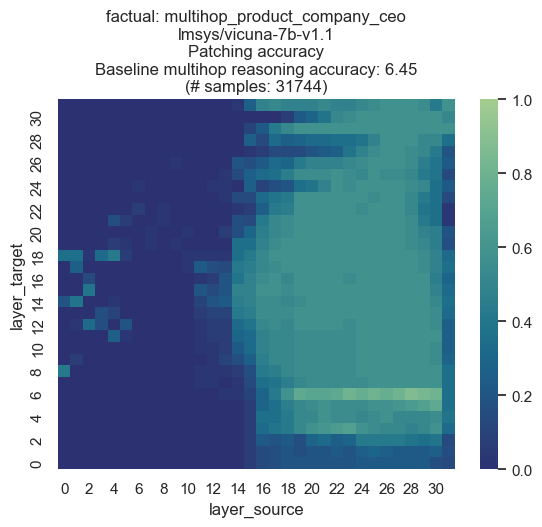

<Figure size 640x480 with 0 Axes>

In [14]:
plot_patching_heatmaps(version="ceo")

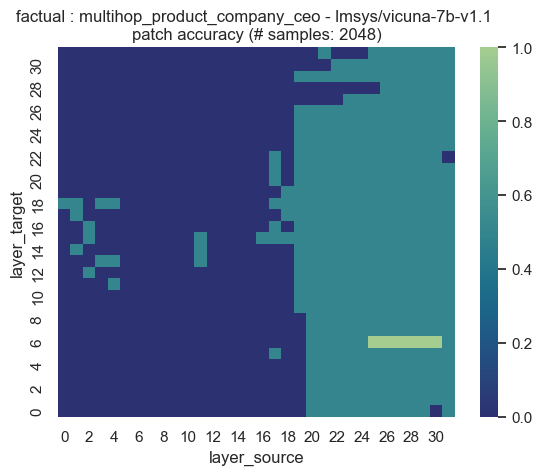

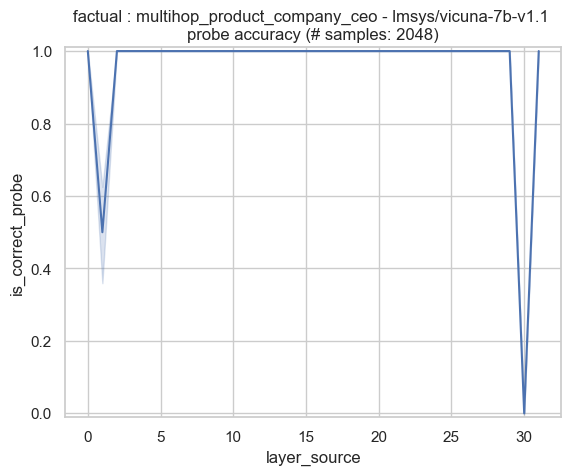

<Figure size 640x480 with 0 Axes>

In [15]:
plot_heatmaps(version="ceo")

# Experiment 2 : CoT experiment subset

This is a subset made only from (product, company) and (company, CEO) tuples from the LRE dataset.
We only picked 3 (company, CEO) tuples, and 15 (product, company) tuples for each that the model is more likely to know the answer to.

This is an exploratory experiment. There is a more complete experiment later in the colab.
Hop 1: Product
Hop 2: company
Hop 3: CEO

The difference between this and experiment 1 is in the choice of source and target prompt template. In this experiment, concatenation of source and target prompt makes a reasonable query, compared to experiment 1 where they where that wasn't the case.

In [16]:
multihop_samples = {
    ("Satya Nadella", "Microsoft"): ["WinDbg", ".NET Framework", "Internet Explorer", "MS-DOS", "Office Open XML",
               "TypeScript", "Bing Maps Platform", "Outlook Express", "PowerShell", "Windows 95",
               "Xbox 360", "Zune", "Visual Basic Script", "Virtual Hard Disk", "Robocopy",
              ],
    ("Tim Cook", "Apple"): ["Siri", "App Store", "CarPlay", "MacBook Air", "Xcode",
               "macOS", "iWork", "Safari", "QuickTime", "TextEdit",
               "WebKit", "QuickDraw", "Time Machine (macOS)", "MessagePad", "Macbook Pro",
              ],
    ("Sundar Pichai", "Google"): ["Chromecast", "Chromebook", "Wear OS", "G Suite", "Picasa",
                "WebP Lossless", "General Transit Feed Specification Lossless", "Cloud Spanner", "Android TV", "Android Runtime",
                "Android Jelly Bean", "Android Auto", "App Inventor", "Chromebook Pixel", "Project Ara",
               ]
}


def generate_CoT_data_prod(fdir_out="./outputs/preprocessed_data_prod_CoT/factual", batch_size=512 // batch_size_scale, max_gen_len=20):
    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    prompt_source_template = "Who is the current CEO of "
    prompt_target_template = "the company that created {}"
    sample_id = 0

    print("Step 1: Prepare dataset...")
    records = []

    for key, value in multihop_samples.items():
        hop3, hop2 = key
        for hop1 in value:
            # hop1: Product
            # hop2: Company
            # hop3: CEO

            records.append({
                "sample_id": sample_id,
                "prompt_source": prompt_source_template,
                "position_source": -1, # always doing next token prediction
                "prompt_target": prompt_target_template.replace("{}", hop1),
                "position_target": -1,

                "baseline_hop2":  f"the company that created {hop1}", #  hop2
                "baseline_hop3":  f"Who is the current CEO of {hop2}", # hop3
                "baseline_multihop3": f"Who is the current CEO of the company that created {hop1}", # hop3

                "hop1": hop1,
                "hop2": hop2,
                "hop3": hop3,
            })
            sample_id +=1

    # Step 2: Compute baseline generations
    print("Step 2: Compute baseline generations...")
    df = pd.DataFrame.from_records(records)
    eval_results = generate_baseline_multihop(mt, df, batch_size=batch_size, max_gen_len=max_gen_len)
    for key, value in eval_results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, "multihop_product_company_ceo.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, "multihop_product_company_ceo.pkl"))

    correct_subset = df[df["is_correct_baseline_hop2"]].reset_index(drop=True)
    correct_subset = correct_subset[correct_subset["is_correct_baseline_hop3"]].reset_index(drop=True)
    correct_subset.to_csv(os.path.join(fdir_out, "multihop_product_company_ceo_only_correct_True.tsv"), sep="\t")
    correct_subset.to_pickle(os.path.join(fdir_out, "multihop_product_company_ceo_only_correct_True.pkl"))
    return df

In [17]:
multihop2_df = generate_CoT_data_prod(batch_size=128 // batch_size_scale, max_gen_len=20)

Step 1: Prepare dataset...
Step 2: Compute baseline generations...


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\NickName\miniconda3\envs\patchscopes\lib\site-packages\transformers\generation\utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


In [18]:
# cot_correct_baseline = run_experiment(
#     "./outputs/preprocessed_data_prod_CoT/factual/multihop_product_company_ceo_only_correct_True.pkl",
#     "./outputs/results_prod_CoT/factual",
#     fname_out = "multihop_product_company_ceo_only_correct_True", batch_size=128 // batch_size_scale, n_samples=-1,
#     save_output=True, replace=False)

In [19]:
# print("Base MultiHop Accuracy: ",
#       cot_correct_baseline.groupby(['sample_id'])["is_correct_baseline_multihop3"].max().reset_index()["is_correct_baseline_multihop3"].mean())
# 
# print("Patching MultiHop Accuracy: ",
#       cot_correct_baseline.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())

# Experimet 3: Main CoT experiment

This is the full version, using maximal amount of data possible from LRE where a multihop question can be formed combining two single-hop questions.

In [20]:
def generate_CoT_data_v7(fname_in="./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop.pkl",
                         fdir_out="./outputs/preprocessed_data_LRE_CoT/factual_multihop", batch_size=512 // batch_size_scale, max_gen_len=20):
    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    fname_pkl = f"{fdir_out}/combined_multihop_CoT_{model_name}_only_correct_True.pkl"
    if os.path.exists(fname_pkl):
        print(f"File {fname_pkl} exists. Skipping...")
        return

    print("Step 1: Read multihop dataset created using LRE data prep...")
    df = pd.read_pickle(fname_in)

    # Step 2: Compute baseline generations
    print("Step 2: Compute baseline generations...")
    eval_results = generate_baseline_multihop(mt, df, batch_size=batch_size, max_gen_len=max_gen_len)
    for key, value in eval_results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, f"combined_multihop_CoT_{model_name}.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, f"combined_multihop_CoT_{model_name}.pkl"))

    correct_subset = df[df["is_correct_baseline_hop2"]].reset_index(drop=True)
    correct_subset = correct_subset[correct_subset["is_correct_baseline_hop3"]].reset_index(drop=True)
    correct_subset.to_csv(os.path.join(fdir_out, f"combined_multihop_CoT_{model_name}_only_correct_True.tsv"), sep="\t")
    correct_subset.to_pickle(os.path.join(fdir_out, f"combined_multihop_CoT_{model_name}_only_correct_True.pkl"))
    return df

In [21]:
# generate_CoT_data_v7(fname_in="./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop.pkl",
#                      fdir_out="./outputs/preprocessed_data_LRE_CoT/factual_multihop",
#                      batch_size=128 // batch_size_scale, max_gen_len=20)

In [ ]:
cot_correct_baseline = run_experiment(
    f"./preprocessed_data/factual_multihop/multihop_CoT_vicuna-13b-v1.1.tsv",
    "./outputs/preprocessed_data/factual_multihop",
    fname_out = f"combined_multihop_CoT_{model_name}_only_correct_True", batch_size=128, n_samples=-1,
    save_output=True, replace=False, tsv=True)

Running experiment on ./preprocessed_data/factual_multihop/multihop_CoT_vicuna-13b-v1.1.tsv...
	Number of samples: 73600


100%|██████████| 32/32 [46:55<00:00, 87.99s/it]


	Number of datapoints for patching experiment: 75366400


  0%|          | 296/588800 [07:34<237:27:31,  1.45s/it]

In [ ]:
efficient_subset = cot_correct_baseline[cot_correct_baseline["layer_source"]<cot_correct_baseline["layer_target"]].reset_index(drop=True)
# TODO maybe run patching for all source x target, but the killer case is when source < target

print("Base MultiHop Accuracy: ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_baseline_multihop3"].max().reset_index()["is_correct_baseline_multihop3"].mean())

print("General Patching MultiHop Accuracy (all source layer x target layer): ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())


print("Efficient Patching MultiHop Accuracy (source layer < target layer): ",
      efficient_subset.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())


In [ ]:
multihop_fname = "./preprocessed_data/factual_multihop/multihop_CoT_vicuna-13b-v1.1.tsv"
df = pd.read_csv(multihop_fname, sep='\t', header=0)
print(len(df))

multihop_fname_only_correct = "./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop_CoT_vicuna-13b-v1.1_only_correct_True.pkl"
df_only_correct = pd.read_pickle(multihop_fname_only_correct)
print(len(df_only_correct))
df_only_correct.groupby(['fname_src', 'fname_target']).count()

In [ ]:
def plot_patching_heatmaps_from_df(patch_df, _vmin=0, _vmax=None, fname_postfix="", save_output=True):
    n_samples = len(patch_df)
    plots_dir = "./outputs/multihop_reasoning"
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    baseline_acc_multihop3 = patch_df["is_correct_baseline_multihop3"].mean()*100
    patching_acc = patch_df.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean() * 100

    heatmap_patched = patch_df.groupby(['layer_target', 'layer_source'])["is_correct_patched"].mean().unstack()

    FONT_SIZE_TITLE = 16
    FONT_SIZE_AXIS = 15

    plt.figure()
    ax = sns.heatmap(data=heatmap_patched, cmap="crest_r", vmin=_vmin, vmax=_vmax)
    ax.invert_yaxis()
    ax.set_title(f"Self-correction in Multi-hop Reasoning\n# samples: {n_samples}", fontsize=FONT_SIZE_TITLE)
    plt.xlabel("Source Layer ($\ell$)", fontsize=FONT_SIZE_AXIS)
    plt.ylabel("Target Layer ($\ell^*$)", fontsize=FONT_SIZE_AXIS)
    plt.tight_layout()
    if save_output:
        fname=f"{plots_dir}/multihop_heatmap{fname_postfix}.pdf"
        plt.savefig(fname, format="pdf", dpi=300, bbox_inches='tight')
        plt.savefig(f"{fname[:-4]}.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

In [ ]:
plot_patching_heatmaps_from_df(efficient_subset, fname_postfix="_source_smaller_than_target")

In [ ]:
plot_patching_heatmaps_from_df(cot_correct_baseline)

# Experiment 4 - CoT Let's think step by step baseline. Baseline

How does a "Let's think step by step" CoT baseline compare with the CoT Patchscope?

In [ ]:
def step_by_step_cot_baseline(
    fname_in=f"./preprocessed_data/factual_multihop/combined_multihop_CoT_{model_name}_only_correct_True.pkl",
    fdir_out="./outputs/results_CoT/factual_multihop",
    fname_out = f"combined_multihop_CoT_{model_name}_only_correct_True_step_by_step",
    batch_size=128 // batch_size_scale,
    max_gen_len=20,
    rewrite=False,
    target_col = "baseline_multihop3",
    object_col = "hop3",
    cot_prefix = "Let's think step by step. "):

    if not os.path.exists(fname_in):
        print(f'File {fname_in} does not exist. Skipping...')
        return

    if not os.path.exists(fdir_out):
        os.makedirs(fdir_out)
    fname_pkl = f"{fdir_out}/{fname_out}.pkl"
    if rewrite==False and os.path.exists(fname_pkl):
        print(f"\t{fname_pkl} exists. Skipping generation. Reading file...")
        df = pd.read_pickle(fname_pkl)
        return df

    print("Computing step-by-step baseline generations...")
    df = pd.read_pickle(fname_in)
    df["cot_prefix"] = cot_prefix

    def _generate_baseline_single_batch(batch_df):
        batch_size = len(batch_df)

        results = {}
        target_baseline_batch = np.array(batch_df[target_col])
        target_baseline_batch = np.core.defchararray.add(cot_prefix, target_baseline_batch.astype(str))
        object_batch = np.array(batch_df[object_col])

        inp_target_baseline = make_inputs(mt.tokenizer, target_baseline_batch, mt.device)
        seq_len_target_baseline = len(inp_target_baseline["input_ids"][0])
        output_target_baseline_toks = mt.model.generate(
            inp_target_baseline["input_ids"],
            max_length=seq_len_target_baseline + max_gen_len,
            pad_token_id=mt.model.generation_config.eos_token_id,
        )[:, seq_len_target_baseline:]
        generations_baseline = decode_tokens(mt.tokenizer, output_target_baseline_toks)
        generations_baseline_txt = np.array([" ".join(sample_gen) for sample_gen in generations_baseline])


        is_correct_baseline = np.array([
            (object_batch[i] in generations_baseline_txt[i] or
             object_batch[i].replace(" ", "") in generations_baseline_txt[i].replace(" ", ""))
            for i in range(batch_size)
        ])
        results.update(
            {
            f"step_by_step_generations_{target_col}": generations_baseline_txt,
            f"step_by_step_is_correct_{target_col}": is_correct_baseline,
            }
        )

        return results

    results = {}
    n_batches = len(df) // batch_size
    if len(df)%batch_size !=0:
        n_batches +=1
    for i in tqdm.tqdm(range(n_batches)):
        cur_df = df.iloc[batch_size * i : batch_size * (i + 1)]
        batch_results = _generate_baseline_single_batch(cur_df)
        for key, value in batch_results.items():
            if key in results:
                results[key] = np.concatenate((results[key], value))
            else:
                results[key] = value

    for key, value in results.items():
        df[key] = list(value)

    df.to_csv(os.path.join(fdir_out, f"{fname_out}.tsv"), sep="\t")
    df.to_pickle(os.path.join(fdir_out, f"{fname_out}.pkl"))
    return df

In [ ]:
cot_correct_baseline_step_by_step_baseline = step_by_step_cot_baseline(
    fname_in=f"./outputs/preprocessed_data_LRE_CoT/factual_multihop/combined_multihop_CoT_{model_name}_only_correct_True.pkl",
    fdir_out="./outputs/results_LRE_CoT/factual_multihop",
    fname_out = f"combined_multihop_CoT_{model_name}_only_correct_True_step_by_step",
    batch_size=128 // batch_size_scale,
    max_gen_len=20,
    target_col = "baseline_multihop3",
    object_col = "hop3",
    cot_prefix = "Let's think step by step. ",
    rewrite=True)

In [ ]:
print("Base MultiHop Accuracy: ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_baseline_multihop3"].max().reset_index()["is_correct_baseline_multihop3"].mean())

print("General Patching MultiHop Accuracy (all source layer x target layer): ",
      cot_correct_baseline.groupby(['sample_id'])["is_correct_patched"].max().reset_index()["is_correct_patched"].mean())


print("Canonical CoT ('Let's think step by step. ') MultiHop Accuracy: ",
      cot_correct_baseline_step_by_step_baseline.groupby(['sample_id'])["step_by_step_is_correct_baseline_multihop3"].max().reset_index()["step_by_step_is_correct_baseline_multihop3"].mean())

In [ ]:
cot_correct_baseline_step_by_step_baseline['step_by_step_generations_baseline_multihop3']
cot_correct_baseline_step_by_step_baseline[['baseline_multihop3', 'hop3', 'generations_baseline_multihop3', 'step_by_step_generations_baseline_multihop3']]